In [13]:
!pip install -q torch torchvision
!pip install -q segment-anything
!pip install -q opencv-python pillow tqdm numpy matplotlib
!pip install -q sam2
!pip install -q albumentations


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import cv2
import os
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import glob

class SealParasiteInstanceDataset(Dataset):
    def __init__(self, img_dir, img_ids, patch_size=1024, stride=512, max_instances=None, augment=True):
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment
        self.max_instances = max_instances

        self.transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
        ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False)) if augment else A.Compose(
            [A.Normalize()], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False)
        )

        self.samples = []
        for img_id in img_ids:
            img_paths = glob.glob(f"{img_dir}/{img_id}/*_proc.png")
            mask_paths = glob.glob(f"{img_dir}/{img_id}/*_mask.npy")
            for img_path, mask_path in zip(sorted(img_paths), sorted(mask_paths)):
                self._index_instances(img_path, mask_path)

    def _index_instances(self, img_path, mask_path):
        mask = np.load(mask_path)
        h, w = mask.shape
        for y in range(0, h - self.patch_size + 1, self.stride):
            for x in range(0, w - self.patch_size + 1, self.stride):
                mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                instance_ids = np.unique(mask_patch)
                instance_ids = instance_ids[instance_ids > 0]
                if instance_ids.size == 0:
                    continue
                self.samples.append({
                    "img_path": img_path,
                    "mask_path": mask_path,
                    "x": x,
                    "y": y,
                    "instance_ids": instance_ids.tolist(),
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = cv2.imread(sample["img_path"])[..., ::-1]
        mask = np.load(sample["mask_path"])

        x, y = sample["x"], sample["y"]
        img_patch = img[y:y+self.patch_size, x:x+self.patch_size]

        masks = []
        keypoints = []
        for inst_id in sample["instance_ids"]:
            inst_mask = (mask[y:y+self.patch_size, x:x+self.patch_size] == inst_id).astype(np.uint8)
            if inst_mask.sum() == 0:
                continue
            masks.append(inst_mask)
            ys, xs = np.nonzero(inst_mask)
            keypoints.append([float(xs.mean()), float(ys.mean())])
        if self.max_instances is not None and len(masks) > self.max_instances:
            areas = np.array([m.sum() for m in masks])
            keep = np.argsort(areas)[-self.max_instances:]
            masks = [masks[i] for i in keep]
            keypoints = [keypoints[i] for i in keep]

        augmented = self.transforms(image=img_patch, masks=masks, keypoints=keypoints)
        img_tensor = torch.from_numpy(augmented["image"].transpose(2, 0, 1)).float()

        mask_tensors = [torch.from_numpy(m.astype(np.float32)) for m in augmented["masks"]]
        mask_stack = torch.stack(mask_tensors, dim=0) if mask_tensors else torch.empty(
            (0, img_tensor.shape[1], img_tensor.shape[2]), dtype=torch.float32
        )

        if augmented["keypoints"]:
            points = torch.tensor(augmented["keypoints"], dtype=torch.float32)
        else:
            points = torch.empty((0, 2), dtype=torch.float32)

        return img_tensor, mask_stack, points

def instance_collate_fn(batch):
    images, mask_stacks, point_stacks = zip(*batch)
    images = torch.stack(images)
    return images, list(mask_stacks), list(point_stacks)

/home/petter/.pyenv/versions/ia-project/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom dataset split - FIXED ASSIGNMENT
output_dir = "Combined_Dataset"  # Your dataset directory

# Define the exact split
splits = {
    'train': ['B2025-00084n', 'B2025-00085e', 'B2025-00085k', 'B2025-00086a',
              'B2025-00130c', 'B2025-00130e', 'B2025-00137b', 'B2025-00137d',
              'B2025-00138b', 'B2025-00142a', 'B2025-00143b'],
    'val': ['B2025-00085.2', 'B2025-00136b'],
    'test': ['B2025-00130b', 'B2025-00139a', 'B2025-00139a-1']
}

print(f"Train: {len(splits['train'])} images")
print(f"Val:   {len(splits['val'])} images")
print(f"Test:  {len(splits['test'])} images")
print(f"\nTrain images: {splits['train']}")
print(f"Val images:   {splits['val']}")
print(f"Test images:  {splits['test']}")

Train: 11 images
Val:   2 images
Test:  3 images

Train images: ['B2025-00084n', 'B2025-00085e', 'B2025-00085k', 'B2025-00086a', 'B2025-00130c', 'B2025-00130e', 'B2025-00137b', 'B2025-00137d', 'B2025-00138b', 'B2025-00142a', 'B2025-00143b']
Val images:   ['B2025-00085.2', 'B2025-00136b']
Test images:  ['B2025-00130b', 'B2025-00139a', 'B2025-00139a-1']


In [9]:
max_instances_per_patch=8

training_set = SealParasiteInstanceDataset("dataset2", splits["train"], max_instances=max_instances_per_patch, augment=True)
validation_set = SealParasiteInstanceDataset("dataset2", splits["val"], max_instances=max_instances_per_patch, augment=False)
test_set = SealParasiteInstanceDataset("dataset2", splits["test"], max_instances=None, augment=False, stride=1024)

train_loader = DataLoader(training_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True, collate_fn=instance_collate_fn)
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=instance_collate_fn)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, collate_fn=instance_collate_fn)

In [4]:
from segment_anything import sam_model_registry

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# Optionally enable LoRA tuning
from peft import get_peft_model, LoraConfig
config = LoraConfig(r=8, lora_alpha=32, target_modules=["attn.qkv", "attn.proj"])
sam = get_peft_model(sam, config)


In [10]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

def sam_forward_logits(sam_model, images):
    image_embeddings = sam_model.image_encoder(images)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(points=None, boxes=None, masks=None)
    low_res_masks, _ = sam_model.mask_decoder(
        image_embeddings=image_embeddings,
        image_pe=sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    return F.interpolate(low_res_masks, size=images.shape[-2:], mode="bilinear", align_corners=False)

def sam_forward_instance_logits(sam_model, images, point_prompts):
    image_embeddings = sam_model.image_encoder(images)
    dense_pe = sam_model.prompt_encoder.get_dense_pe()
    instance_logits = []
    for batch_idx in range(images.size(0)):
        per_image_logits = []
        points = point_prompts[batch_idx].to(images.device, dtype=torch.float32)
        if points.numel() == 0:
            instance_logits.append(torch.empty(0, 1, images.shape[-2], images.shape[-1], device=images.device))
            continue
        for point in points:
            point_input = point.view(1, 1, 2)
            point_input = point_input.to(images.device, dtype=torch.float32)
            point_labels = torch.ones(1, 1, device=images.device, dtype=torch.float32)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=(point_input, point_labels),
                boxes=None,
                masks=None,
            )
            low_res_masks, _ = sam_model.mask_decoder(
                image_embeddings=image_embeddings[batch_idx:batch_idx + 1],
                image_pe=dense_pe,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            upsampled = F.interpolate(
                low_res_masks,
                size=images.shape[-2:],
                mode="bilinear",
                align_corners=False,
            )
            per_image_logits.append(upsampled.squeeze(0))
        if per_image_logits:
            instance_logits.append(torch.stack(per_image_logits, dim=0))
        else:
            instance_logits.append(torch.empty(0, 1, images.shape[-2], images.shape[-1], device=images.device))
    return instance_logits

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(-2, -1))
    den = probs.sum(dim=(-2, -1)) + targets.sum(dim=(-2, -1)) + eps
    return 1 - (num / den).mean()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(sam.parameters(), lr=1e-4)
num_epochs = 10
best_val_loss = float("inf")
best_ckpt_path = "sam_instance_best.pth"
final_ckpt_path = "sam_instance_final.pth"

for epoch in range(num_epochs):
    sam.train()
    total_loss = 0.0
    train_batches = 0
    for imgs, mask_stacks, point_stacks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)
        mask_stacks = [m.to(device) for m in mask_stacks]

        preds_list = sam_forward_instance_logits(sam, imgs, point_stacks)

        loss = 0.0
        valid_samples = 0
        for preds, targets in zip(preds_list, mask_stacks):
            if preds.shape[0] == 0 or targets.shape[0] == 0:
                continue
            targets = targets.unsqueeze(1)
            loss += criterion(preds, targets) + dice_loss(preds, targets)
            valid_samples += 1

        if valid_samples == 0:
            continue

        loss = loss / valid_samples
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_batches += 1

    avg_train = total_loss / max(train_batches, 1)

    sam.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for imgs, mask_stacks, point_stacks in validation_loader:
            imgs = imgs.to(device)
            mask_stacks = [m.to(device) for m in mask_stacks]

            preds_list = sam_forward_instance_logits(sam, imgs, point_stacks)

            batch_loss = 0.0
            valid_samples = 0
            for preds, targets in zip(preds_list, mask_stacks):
                if preds.shape[0] == 0 or targets.shape[0] == 0:
                    continue
                targets = targets.unsqueeze(1)
                batch_loss += criterion(preds, targets) + dice_loss(preds, targets)
                valid_samples += 1

            if valid_samples == 0:
                continue

            val_loss += (batch_loss / valid_samples).item()
            val_batches += 1

    avg_val = val_loss / max(val_batches, 1)
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(
            {"epoch": epoch + 1, "val_loss": avg_val, "model_state": sam.state_dict()},
            best_ckpt_path,
        )
        print(f"Saved best checkpoint to {best_ckpt_path}")
    print(f"Epoch {epoch+1}: train_loss={avg_train:.4f} | val_loss={avg_val:.4f}")

torch.save(
    {"epoch": num_epochs, "val_loss": avg_val, "model_state": sam.state_dict()},
    final_ckpt_path,
)
print(f"Saved final checkpoint to {final_ckpt_path}")

Epoch 1/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 1: train_loss=0.1105 | val_loss=0.1120


Epoch 2/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 2: train_loss=0.1097 | val_loss=0.1141


Epoch 3/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 3: train_loss=0.1036 | val_loss=0.1121


Epoch 4/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 4: train_loss=0.1001 | val_loss=0.1184


Epoch 5/10: 100%|██████████| 328/328 [01:24<00:00,  3.89it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 5: train_loss=0.1026 | val_loss=0.1114


Epoch 6/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 6: train_loss=0.1010 | val_loss=0.1087


Epoch 7/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 7: train_loss=0.0958 | val_loss=0.1125


Epoch 8/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 8: train_loss=0.0953 | val_loss=0.1118


Epoch 9/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 9: train_loss=0.0922 | val_loss=0.1113


Epoch 10/10: 100%|██████████| 328/328 [01:23<00:00,  3.93it/s]


Epoch 10: train_loss=0.0930 | val_loss=0.1180
Saved final checkpoint to sam_instance_final.pth


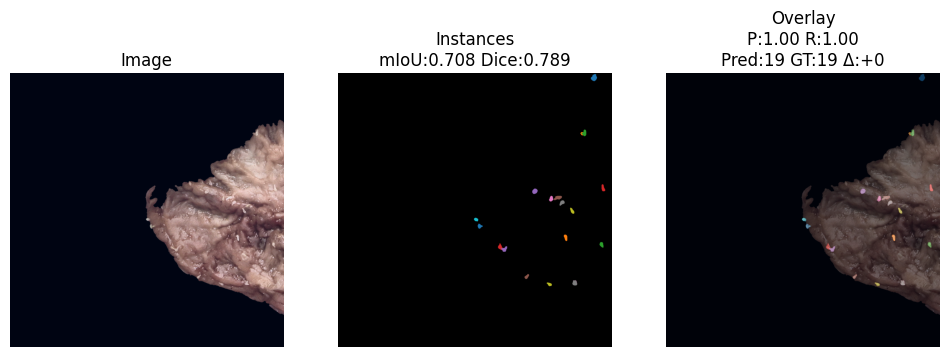

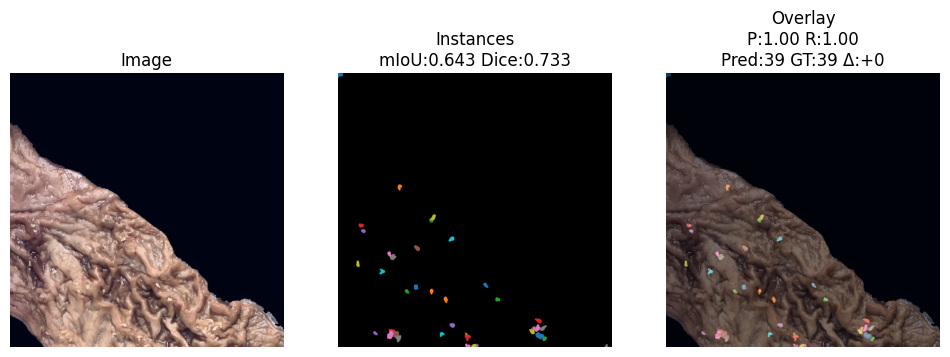

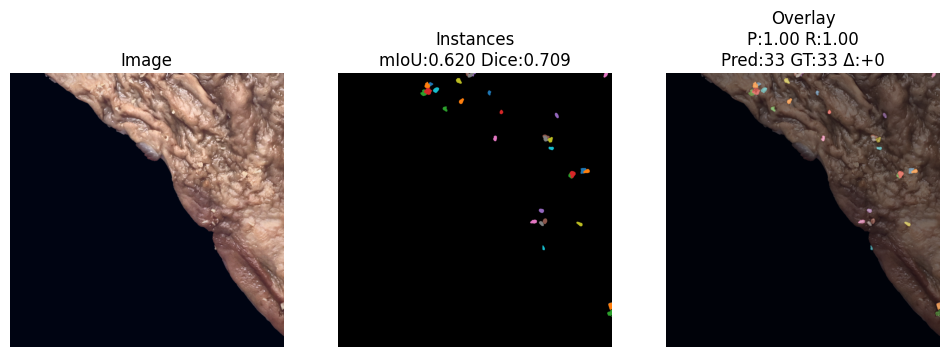

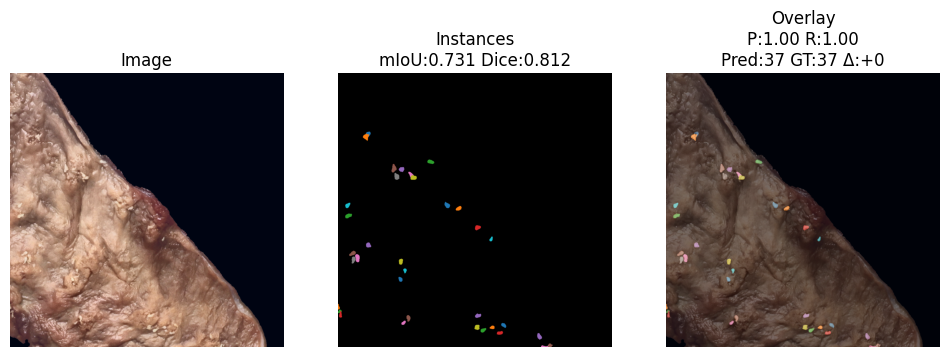

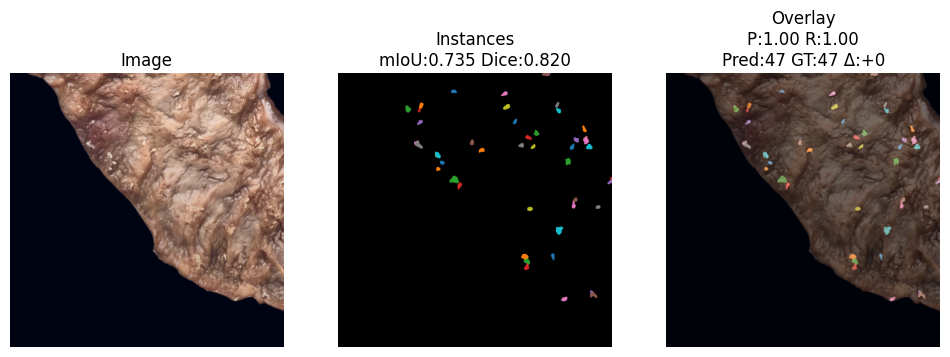

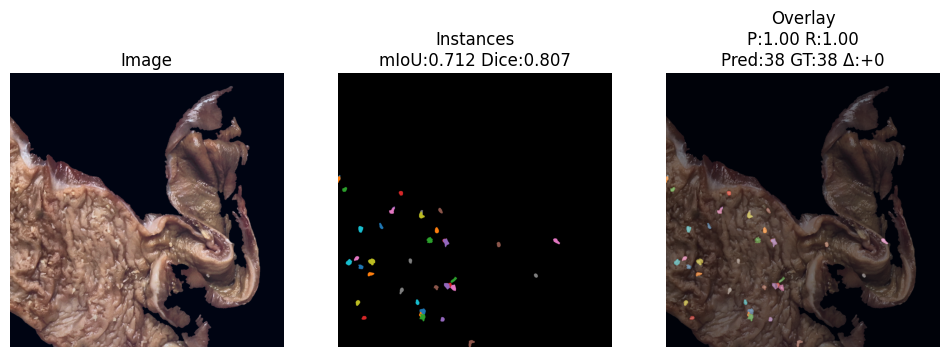

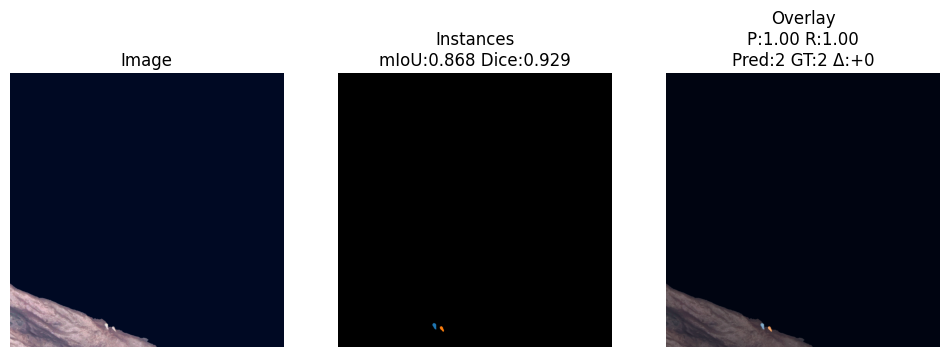

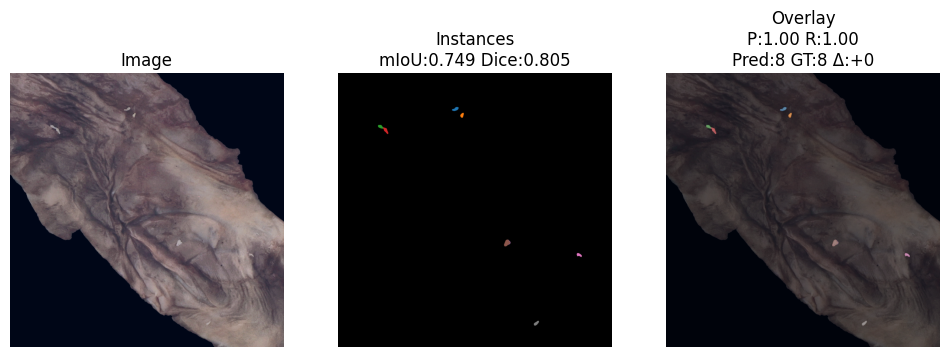

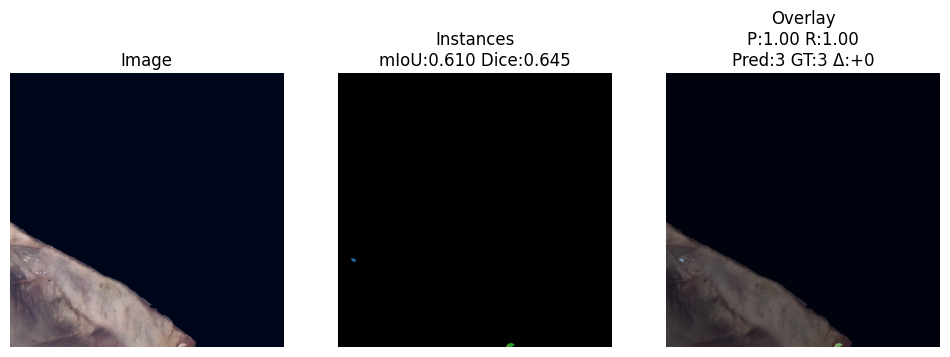

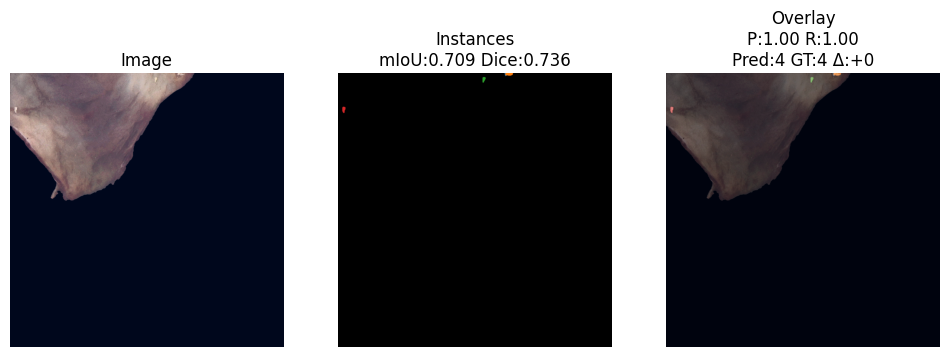

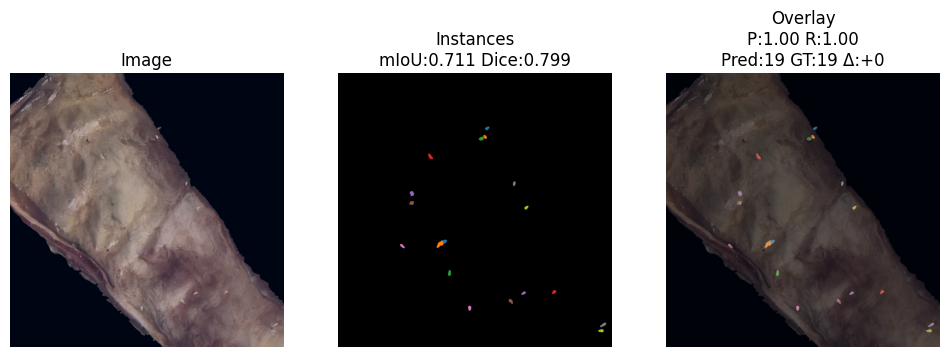

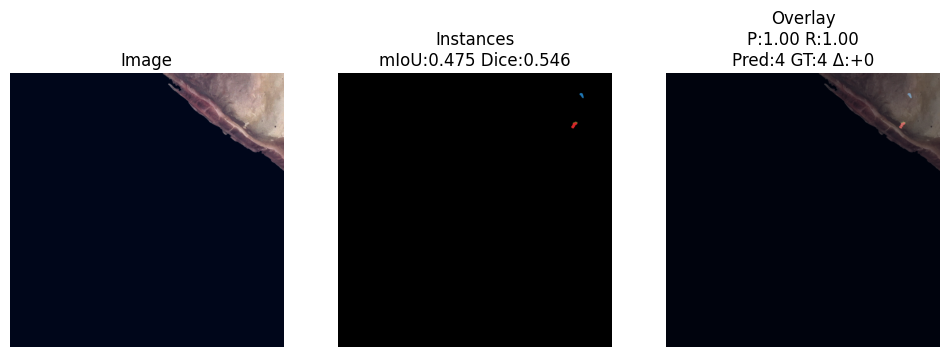

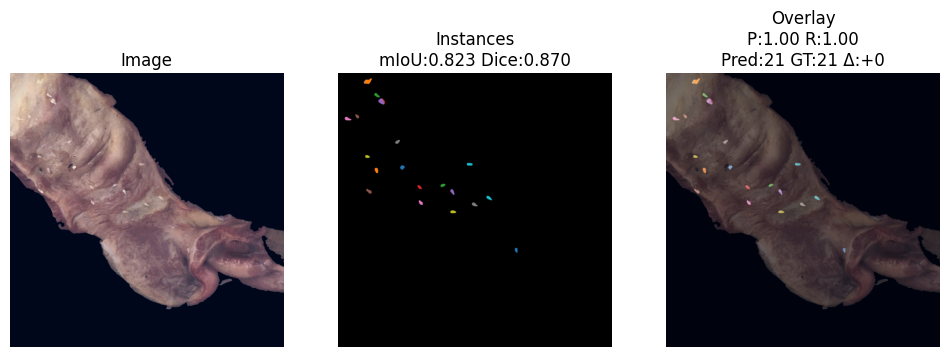

In [14]:
sam.load_state_dict(torch.load(best_ckpt_path)["model_state"])
sam.eval()

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def match_instance_metrics(pred_masks, gt_masks):
    if pred_masks.ndim == 4:
        pred_masks = pred_masks[:, 0]
    if isinstance(gt_masks, torch.Tensor):
        gt_masks = gt_masks.cpu().numpy()
    if isinstance(pred_masks, torch.Tensor):
        pred_masks = pred_masks.cpu().numpy()
    if pred_masks.size == 0 and gt_masks.size == 0:
        return {"matched": 0, "precision": 1.0, "recall": 1.0, "mean_iou": 1.0, "mean_dice": 1.0}
    if pred_masks.size == 0:
        return {"matched": 0, "precision": 0.0, "recall": 0.0, "mean_iou": 0.0, "mean_dice": 0.0}
    if gt_masks.size == 0:
        return {"matched": 0, "precision": 0.0, "recall": 1.0, "mean_iou": 0.0, "mean_dice": 0.0}

    num_pred = pred_masks.shape[0]
    num_gt = gt_masks.shape[0]
    pred_flat = pred_masks.reshape(num_pred, -1)
    gt_flat = gt_masks.reshape(num_gt, -1)

    intersection = np.logical_and(pred_flat[:, None, :], gt_flat[None, :, :]).sum(axis=-1)
    union = np.logical_or(pred_flat[:, None, :], gt_flat[None, :, :]).sum(axis=-1) + 1e-6
    iou = intersection / union
    dice = (2 * intersection) / (pred_flat.sum(axis=-1, keepdims=True) + gt_flat.sum(axis=-1) + 1e-6)

    matched_pairs = []
    iou_copy = iou.copy()
    while True:
        max_idx = np.unravel_index(np.argmax(iou_copy), iou_copy.shape)
        if iou_copy[max_idx] <= 0:
            break
        matched_pairs.append(max_idx)
        iou_copy[max_idx[0], :] = -1
        iou_copy[:, max_idx[1]] = -1

    if not matched_pairs:
        return {"matched": 0, "precision": 0.0, "recall": 0.0, "mean_iou": 0.0, "mean_dice": 0.0}

    matched_iou = [iou[p, g] for p, g in matched_pairs]
    matched_dice = [dice[p, g] for p, g in matched_pairs]

    return {
        "matched": len(matched_pairs),
        "precision": len(matched_pairs) / max(num_pred, 1),
        "recall": len(matched_pairs) / max(num_gt, 1),
        "mean_iou": float(np.mean(matched_iou)),
        "mean_dice": float(np.mean(matched_dice)),
    }

def visualize_predictions(loader, limit=5):
    shown = 0
    with torch.no_grad():
        for imgs, mask_stacks, point_stacks in loader:
            imgs = imgs.to(device)
            preds_list = sam_forward_instance_logits(sam, imgs, point_stacks)
            imgs_np = imgs.cpu().numpy().transpose(0, 2, 3, 1)

            for img_np, preds, gt_masks in zip(imgs_np, preds_list, mask_stacks):
                if preds.shape[0] == 0 and gt_masks.shape[0] == 0:
                    continue
                probs = torch.sigmoid(preds).cpu().numpy()
                binary_masks = (probs > 0.5).astype(np.uint8)

                metrics = match_instance_metrics(binary_masks, gt_masks.numpy())
                pred_count = binary_masks.shape[0]
                gt_count = gt_masks.shape[0]
                count_gap = pred_count - gt_count

                base_img = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-6)
                color_mask = np.zeros_like(base_img)
                for inst_idx, inst_mask in enumerate(binary_masks):
                    color = np.array(cm.tab10(inst_idx % 10)[:3], dtype=np.float32)
                    color_mask[inst_mask[0] == 1] = color

                overlay = np.clip(0.5 * base_img + 0.5 * color_mask, 0.0, 1.0)

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(base_img)
                axes[0].set_title("Image")
                axes[1].imshow(color_mask)
                axes[1].set_title(
                    f"Instances\nmIoU:{metrics['mean_iou']:.3f} Dice:{metrics['mean_dice']:.3f}"
                )
                axes[2].imshow(overlay)
                axes[2].set_title(
                    f"Overlay\nP:{metrics['precision']:.2f} R:{metrics['recall']:.2f}\nPred:{pred_count} GT:{gt_count} Δ:{count_gap:+d}"
                )
                for ax in axes:
                    ax.axis("off")
                plt.show()

                shown += 1
                if shown >= limit:
                    return

visualize_predictions(test_loader, limit=60)